# Analisis De Textos

1. De que tratan las empresas que se estan consitituyendo? NLP en descripcion de actividades.
2. Hay algun patron geografico? (x ej con https://kepler.gl/)
3. Hay cambios a lo largo del tiempo? Algún peak interesante?
4. Qué características de empresa tienden a pedir cuenta corriente y cuáles no?
5. Cuánto tiempo pasa entre que una empresa se constituye y solicitan una cuenta corriente?
6. Podemos ver alguna red de RUTs? Gente que esta relacionada en varias empresas (quizas con https://www.graphext.com/)


In [1]:
#!pip install awswrangler
#!pip install --upgrade seaborn
#!pip install wordcloud
#!pip install --upgrade pandas
#!pip install unidecode
#!pip install gensim

In [2]:
import boto3

session = boto3.session.Session(profile_name='legalbot')
s3 = session.resource('s3')

In [3]:
import pandas as pd
import awswrangler as wr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context('poster')

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,8

In [4]:
bucket='legalres-storage-study-json'
prefix = 'processed'
data_location = 's3://{}/{}/'.format(bucket, prefix)

In [5]:
df = wr.s3.read_parquet(path=data_location,
                        boto3_session=session)

In [6]:
df.shape

(798060, 7)

In [7]:
df.columns

Index(['rut', 'cve', 'fecha', 'lugar', 'tipo_sociedad', 'objeto', 'firmas'], dtype='object')

In [8]:
df.head()

,rut,cve,fecha,lugar,tipo_sociedad,objeto,firmas
0,76304233-2,AC1DrSkE1pdl,2013-10-08,"En TEMUCO, Región de LA ARAUCANIA, Chile, a 08...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
1,76304089-5,AC1Dv0J0V4Zr,2013-10-07,"En CONCEPCION, Región del BIOBIO, Chile, a 07 ...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
2,76313238-2,AC1G6RzRn16K,2013-10-24,"En MOLINA, Región del MAULE, Chile, a 24 de oc...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
3,76313389-3,AC1G8rKdG7Xu,2013-10-24,"En COPIAPO, Región de ATACAMA, Chile, a 24 de ...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
4,76313805-4,AC1H6Pt61S4o,2013-10-29,"En TALCA, Región del MAULE, Chile, a 29 de oct...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."


## Analisis de Texto 

In [9]:
TEXT_COL = 'objeto'
PROCESSED = 'objeto_processed'
SAMPLES = 30000

### Limpieza 

In [10]:
# Load the regular expression library
import re
# Remove punctuation
df[PROCESSED] = \
df[TEXT_COL].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df[PROCESSED] = \
df[PROCESSED].map(lambda x: x.lower())
# Print out the first rows of papers
df[PROCESSED].head()

import unidecode

df[PROCESSED] = \
df[PROCESSED].map(lambda x: unidecode.unidecode(x))

Remover introduccion repetitiva

In [11]:
remove = ['la empresa tendra por objeto desarrollar las siguientes actividades:',
          'la sociedad tendra por objeto desarrollar las siguientes actividades:',
          'la actividad economica que constituira el objeto o el giro de la empresa sera :',
          'el la sociedad tiene por objeto la',
          'el objeto de la sociedad sera:',
          'objeto de la sociedad sera',
          'el objeto de la sociedad es',
          'la sociedad tendra como objeto unico',
          'prestacion de',
          'al por',
          'el objeto de la empresa sera',
          'objeto social',
          'actividad',
          'actividades',
          'cualquier otra',
          'la sociedad tiene por objeto',
          'en general',
          'clase de',
          'cuenta propia',
          'y de',
          'todo tipo',
          'toda',
          'relacionadas con',
          'clase',
          'socios',
          'podra',
          'realizar',
          'la sociedad',
          'realizacion',
          'otras'
          ]
for s in remove:
#    df[PROCESSED] = df[PROCESSED].apply(lambda x: re.sub(' ' + s + ' ', '', ' ' + x + ' '))
    s = ' ' + s + ' '
    df[PROCESSED] = [re.sub(s, '', ' ' + x + ' ').strip() for x in df[PROCESSED].values]

In [12]:
df.loc[df[PROCESSED].str.contains('sarollo')]

,rut,cve,fecha,lugar,tipo_sociedad,objeto,firmas,objeto_processed
12809,76288225-6,ACVUceUxvMgC,2013-06-04,"En INDEPENDENCIA, Región METROPOLITANA DE SANT...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,"La Sociedad tendrá por objeto desarrollar, dir...","[{'anotacion': None, 'firmado': 'Firmado elect...",tendra por objeto...
16866,76294815-K,ACKSo4So1vfr,2013-08-23,"En LA FLORIDA, Región METROPOLITANA DE SANTIAG...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect...",desarollo y comer...
17899,76294391-3,ACnv3LFKU7FV,2013-08-20,"En HUECHURABA, Región METROPOLITANA DE SANTIAG...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect...",desarollo de ases...
32017,76439562-K,ACinqc1vb1ET,2014-11-03,"En LA SERENA, Región de COQUIMBO, Chile, a 03 ...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect...",el desarrollo y p...
32338,76441105-6,ACmyTu2JhHyq,2014-11-05,"En LAS CONDES, Región METROPOLITANA DE SANTIAG...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect...",investigacion teo...
...,...,...,...,...,...,...,...,...
773932,77428306-4,ACSoCGXKVH1l,2021-08-24,"En SANTIAGO, Región METROPOLITANA DE SANTIAGO,...",SOCIEDAD POR ACCIONES,"El objeto de la sociedad será DISEÑO, FABRICAC...","[{'anotacion': None, 'firmado': 'Firmado elect...",eldiseno fabrica...
782545,77433374-6,ACxLk2YdCnXI,2021-08-31,"En IQUIQUE, Región de TARAPACA, Chile, a 31 de...",SOCIEDAD POR ACCIONES,El objeto de la sociedad será Consultorias y a...,"[{'anotacion': None, 'firmado': 'Firmado elect...",elconsultorias y...
787366,77445164-1,ACHo1EFGl1yq,2021-09-21,"En VALPARAISO, Región de VALPARAISO, Chile, a ...",SOCIEDAD POR ACCIONES,El objeto de la sociedad será El objeto social...,"[{'anotacion': None, 'firmado': 'Firmado elect...",elelde la empres...
788599,77434273-7,ACMqbQWnErkC,2021-09-01,"En VITACURA, Región METROPOLITANA DE SANTIAGO,...",SOCIEDAD POR ACCIONES,"El objeto de la sociedad será a) La compra, ve...","[{'anotacion': None, 'firmado': 'Firmado elect...",ela) la compra v...


In [13]:
df.loc[41, PROCESSED]

'                             laservicios alimenticios explotacion de restaurantes preparacion produccion comercializacion fabricacion distribucion compra y venta dede alimentos fuente de soda cafeteria y cualquier otrarelacionada con las anteriores que losde comun acuerdo determinen tengan o no relacion con el                             '

### Word Cloud

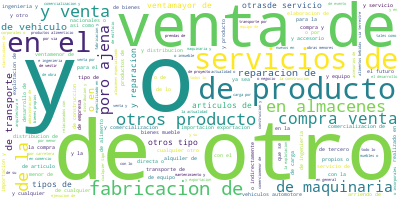

In [14]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df[PROCESSED].sample(SAMPLES).values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Tune Topic Model 

Preparar data

In [90]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
stop_words.extend(['actividades', 'venta', 'al por', 'sociedad', 'general', 'toda', 'clase', 'cualquier', 'tipo', 'desarrollo'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df[PROCESSED].sample(SAMPLES).values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /Users/jaime/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['servicios', 'instalacion', 'tuberias', 'mineria', 'industrias', 'fabricacion', 'piezas', 'hdpe', 'termofusion', 'fabricacion', 'muebles', 'rusticos', 'tales', 'efectos', 'desarrolllas', 'comerciales', 'fabricar', 'comprar', 'vender', 'importar', 'exportar', 'arrendar', 'instalar', 'trasladar', 'equipos', 'vender', 'insumos', 'implementos', 'instrumental', 'materiales']


In [91]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1)]


In [92]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.023*"productos" + 0.016*"fabricacion" + 0.012*"servicios" + 0.012*"obras" '
  '+ 0.011*"construccion" + 0.011*"elaboracion" + 0.011*"exportacion" + '
  '0.010*"importacion" + 0.010*"compra" + 0.009*"bebidas"'),
 (1,
  '0.043*"productos" + 0.033*"servicios" + 0.025*"fabricacion" + 0.022*"mayor" '
  '+ 0.022*"menor" + 0.016*"almacenes" + 0.015*"especializados" + '
  '0.012*"comercimenor" + 0.011*"vehiculos" + 0.011*"construccion"'),
 (2,
  '0.019*"productos" + 0.016*"servicios" + 0.014*"compra" + 0.013*"articulos" '
  '+ 0.012*"importacion" + 0.011*"construccion" + 0.011*"distribucion" + '
  '0.011*"exportacion" + 0.008*"bienes" + 0.007*"obras"'),
 (3,
  '0.026*"bienes" + 0.018*"servicios" + 0.011*"muebles" + 0.011*"inmuebles" + '
  '0.010*"productos" + 0.010*"sociedades" + 0.009*"administracion" + '
  '0.009*"compra" + 0.008*"inversiones" + 0.008*"ajena"'),
 (4,
  '0.025*"servicios" + 0.012*"construccion" + 0.009*"distribucion" + '
  '0.009*"proyectos" + 0.009*"obras" + 0.009*

In [93]:
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('../reports/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself



pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '../reports/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.087910 -0.026662       1        1  20.300895
4     -0.060164 -0.042200       2        1  13.545154
2     -0.017061 -0.059787       3        1  11.761078
9     -0.019816  0.114852       4        1  11.601126
1      0.069113  0.053421       5        1   9.902133
8      0.011714  0.040178       6        1   8.997576
6     -0.086978  0.009663       7        1   7.205130
0      0.023170 -0.005446       8        1   6.352911
7      0.122066 -0.038969       9        1   5.303936
5      0.045865 -0.045051      10        1   5.030059, topic_info=           Term          Freq         Total Category  logprob  loglift
151  transporte   5841.000000   5841.000000  Default  30.0000  30.0000
119   productos  12093.000000  12093.000000  Default  29.0000  29.0000
223       menor   5701.000000   5701.000000  Default  28.0000  28.0000
33    servicios  18332.000000  18332.000000  Default  27.0000  27.0000
114   articulos   5094.000000   5094.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
128     civiles    176.006962   1622.967518  Topic10  -5.3288   0.7683
61    proyectos    197.815498   2391.611947  Topic10  -5.2119   0.4974
217   alimentos    210.026425   3117.310959  Topic10  -5.1520   0.2922
46       compra    188.728446   6223.589594  Topic10  -5.2590  -0.5061
114   articulos    186.487134   5094.237776  Topic10  -5.2709  -0.3178

[909 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
4807       3  0.775215  acabadedificio
259        1  0.105963      accesorios
259        2  0.099560      accesorios
259        3  0.117487      accesorios
259        4  0.158784      accesorios
...      ...       ...             ...
14835      3  0.782151        vitrinas
9747       9  0.848376     vitrofusion
5863       5  0.857747             vta
6868       3  0.717397            vtas
7515       3  0.871286         yogures

[3864 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 10, 2, 9, 7, 1, 8, 6])

### Expand model to all data

In [131]:
predicted_topics = [lda_model[id2word.doc2bow(x.split())] for x in df[PROCESSED].values]

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [132]:
len(predicted_topics)

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


798060

In [142]:
for topic, prob in predicted_topics[1]:
    print (topic, prob)

1 0.8318563
8 0.11098954


/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [138]:
def find_max_topic(keypairs):
    maxprob = 0
    selected_topic = 0
    for topic, prob in keypairs:
        if prob > maxprob:
            maxprob = prob
            selected_topic = topic
    
    return selected_topic

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [144]:
selected_topics = [find_max_topic(x) for x in predicted_topics]

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [145]:
df['topic'] = selected_topics

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [146]:
df.head()

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rut,cve,fecha,lugar,tipo_sociedad,objeto,firmas,objeto_processed,topic
0,76304233-2,AC1DrSkE1pdl,2013-10-08,"En TEMUCO, Región de LA ARAUCANIA, Chile, a 08...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect...",ejecucion trabajos obras servicios vinculados ...,4
1,76304089-5,AC1Dv0J0V4Zr,2013-10-07,"En CONCEPCION, Región del BIOBIO, Chile, a 07 ...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect...",construccion fab productos madera materiales t...,1
2,76313238-2,AC1G6RzRn16K,2013-10-24,"En MOLINA, Región del MAULE, Chile, a 24 de oc...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect...",fabricacion reparacion comercializacion e impo...,1
3,76313389-3,AC1G8rKdG7Xu,2013-10-24,"En COPIAPO, Región de ATACAMA, Chile, a 24 de ...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect...",servicios informaticos comercimenor nrealizade...,1
4,76313805-4,AC1H6Pt61S4o,2013-10-29,"En TALCA, Región del MAULE, Chile, a 29 de oct...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect...",objetla sociedad es: a) preparacion construcci...,4


## Share de cada topic 

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Text(0.5, 1.0, 'Volumen de Empresas Creadas Segun Tipo de Empresa')]

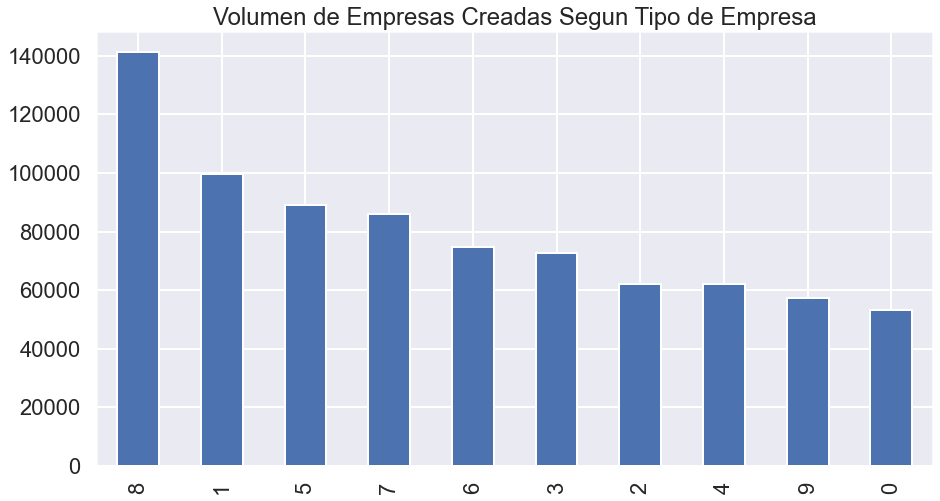

In [166]:
df['topic'].value_counts().plot.bar().set(title='Volumen de Empresas Creadas Segun Tipo de Empresa')

## Volumen de topicos over time

In [177]:
volumen = df.groupby([pd.Grouper(key='fecha', freq='m'), 'topic'])['rut'].count().unstack('topic')

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  sigint_future.set_result(1)


In [178]:
col_order = list(df['topic'].value_counts().index)
volumen = volumen.loc[:, col_order]

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  sigint_future.set_result(1)


/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  sigint_future.set_result(1)


[Text(0.5, 1.0, 'CONSTITUCIONES Mensuales by Tipo de Empresa')]

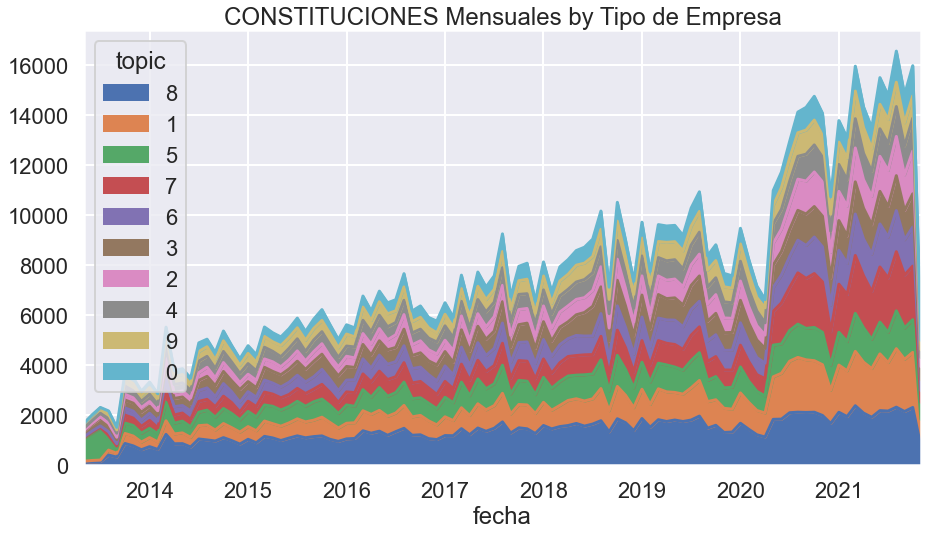

In [179]:
volumen.plot.area().set(title='CONSTITUCIONES Mensuales by Tipo de Empresa')

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  sigint_future.set_result(1)


[Text(0.5, 1.0, '% CONSTITUCIONES Mensuales by Tipo de Empresa')]

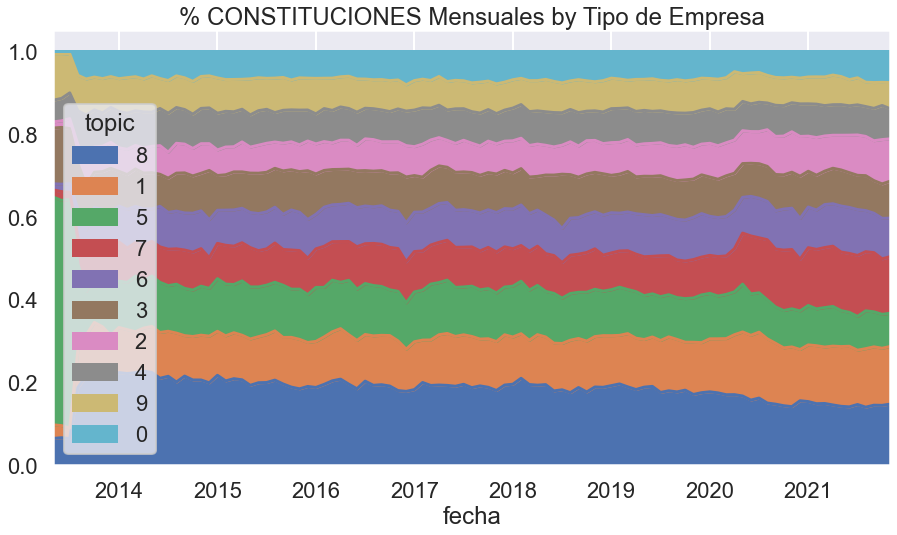

In [181]:
volumen_pct = volumen.div(volumen.sum(axis=1), axis=0)
volumen_pct.plot.area().set(title='% CONSTITUCIONES Mensuales by Tipo de Empresa')